In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_excel("Data/tr.xlsx",)

In [2]:
over_missing_sample = []
row_value_count = train_data.apply(pd.Series.value_counts,axis=1,dropna=False)

In [3]:
import tools
#Data transform
train_y = pd.DataFrame(train_data['outcome']) 
train_X = pd.DataFrame(train_data.drop(['outcome'],axis=1))

train_X = tools.data_transform(train_X)

In [4]:
threshhold =len(train_X.columns)*0.25
over_missing = row_value_count[np.nan]<=threshhold
class_0 = train_y['outcome']==1

print(sorted(train_y.value_counts()))
train_X = train_X[over_missing|class_0]
train_y = train_y[over_missing|class_0]
print(sorted(train_y.value_counts()))


[879, 51280]
[879, 27076]


In [5]:
# Data split
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(
    train_X ,
    train_y,
    test_size=0.2,
    random_state=42)

print(sorted(train_y.value_counts()))
print(sorted(val_y.value_counts()))

[718, 21646]
[161, 5430]


In [6]:
from imblearn.under_sampling import RandomUnderSampler as RUS

print(sorted(train_y.value_counts()))

rus = RUS(sampling_strategy=0.1,random_state=42)
train_X,train_y = rus.fit_resample(train_X,train_y)

print(sorted(train_y.value_counts()))

[718, 21646]
[718, 7180]


In [7]:
from sklearn.feature_selection import VarianceThreshold as VT

vt= VT(0.2)

vt.fit(train_X)
print(train_X.shape)

train_X = pd.DataFrame(vt.transform(train_X)) 
val_X =  pd.DataFrame(vt.transform(val_X))

print(train_X.shape)

(7898, 66)
(7898, 30)


In [8]:
# Missing value imputation
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tools
feature_kind = tools.init_feature_kind(train_X)
cont,cate = tools.get_feature_kind(train_X,feature_kind)  

strategy = 'median'

imp_mean = IterativeImputer(max_iter=100,random_state=0)
imp_mean.fit(train_X[cont])

train_X[cont] = imp_mean.transform(train_X[cont])
val_X[cont] = imp_mean.transform(val_X[cont])

print("filled continuous missing value with "+strategy)

strategy = 'constant'

imp = SimpleImputer(missing_values=np.nan, strategy=strategy,fill_value=10.0)
imp.fit(train_X[cate])

train_X[cate] = imp.transform(train_X[cate])
val_X[cate] = imp.transform(val_X[cate])


print("filled nominal missing value with ",strategy)


filled continuous missing value with median
filled nominal missing value with  constant


In [9]:
from sklearn import preprocessing


cont,cate = tools.get_feature_kind(train_X,feature_kind)

scaler = preprocessing.StandardScaler().fit(train_X[cont])
train_X[cont] = scaler.transform(train_X[cont])
val_X[cont] = scaler.transform(val_X[cont])

In [10]:
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
clf = DT(random_state=42,class_weight={0:0.1,1:1})

parameters = {
    'criterion':('gini','entropy'),
    'splitter':('best','random')

    }

GS = GridSearchCV(clf, parameters,n_jobs=5,scoring='f1')
GS.fit(train_X, train_y['outcome'])


sorted(GS.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_criterion',
 'param_splitter',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [11]:
print(GS.best_params_)
print(pd.DataFrame(GS.cv_results_))

{'criterion': 'entropy', 'splitter': 'best'}
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.111826      0.009285         0.004002        0.000634   
1       0.026405      0.000490         0.003001        0.000632   
2       0.141239      0.008135         0.003400        0.000491   
3       0.023806      0.002137         0.003401        0.000490   

  param_criterion param_splitter  \
0            gini           best   
1            gini         random   
2         entropy           best   
3         entropy         random   

                                           params  split0_test_score  \
0       {'criterion': 'gini', 'splitter': 'best'}           0.588235   
1     {'criterion': 'gini', 'splitter': 'random'}           0.609319   
2    {'criterion': 'entropy', 'splitter': 'best'}           0.590604   
3  {'criterion': 'entropy', 'splitter': 'random'}           0.617450   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score

In [33]:
from sklearn.feature_selection import RFE

best_parameters = {'criterion': 'entropy', 'splitter': 'best'}


clf = DT(**best_parameters,random_state=42,class_weight={0:0.1,1:1})

clf.fit(train_X, train_y['outcome'])
result = clf.predict(val_X)


print(pd.DataFrame({
    'train':tools.get_performance(train_y,clf.predict(train_X)),
    'val':tools.get_performance(val_y,result)
    }
    ))




                                   train                       val
confusion matrix   [[7180, 0], [0, 718]]  [[5226, 204], [58, 103]]
acc                                  1.0                  0.953139
precision                            1.0                  0.335505
f1_score                             1.0                  0.440171
recall                               1.0                  0.639752
matthews_corrcoef                    1.0                  0.442069


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

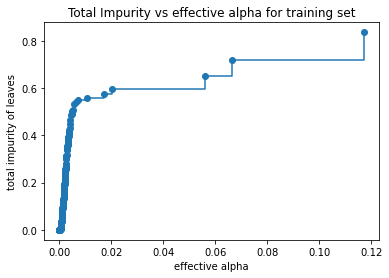

In [34]:
import matplotlib.pyplot as plt
path = clf.cost_complexity_pruning_path(train_X, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [35]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DT(**best_parameters,random_state=42,class_weight={0:0.1,1:1}, ccp_alpha=ccp_alpha)
    clf.fit(train_X, train_y)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)


Number of nodes in the last tree is: 1 with ccp_alpha: 0.16408572038811753


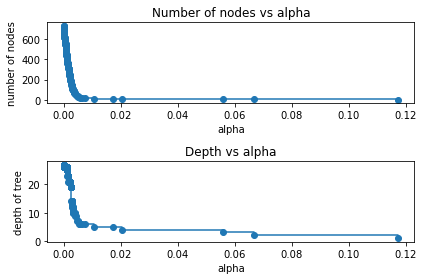

In [36]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

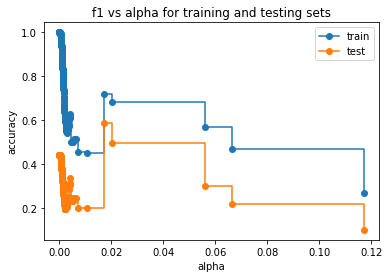

In [37]:
from sklearn.metrics import f1_score
train_scores = [f1_score(train_y, clf.predict(train_X)) for clf in clfs]
test_scores = [f1_score(val_y, clf.predict(val_X)) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("f1 vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [38]:

ccp_alpha = ccp_alphas[np.argmax(test_scores)]

In [39]:
from sklearn.feature_selection import RFE

best_parameters = {'criterion': 'entropy', 'splitter': 'best'}


clf = DT(**best_parameters,random_state=42,class_weight={0:0.1,1:1},ccp_alpha=ccp_alpha)

clf.fit(train_X, train_y['outcome'])
result = clf.predict(val_X)


print(pd.DataFrame({
    'train':tools.get_performance(train_y,clf.predict(train_X)),
    'val':tools.get_performance(val_y,result)
    }
    ))




                                       train                      val
confusion matrix   [[7074, 106], [255, 463]]  [[5350, 80], [61, 100]]
acc                                 0.954292                 0.974781
precision                           0.813708                 0.555556
f1_score                            0.719503                  0.58651
recall                              0.644847                 0.621118
matthews_corrcoef                   0.700558                 0.574495
